## 1. Subscribe to the model package

To subscribe to the model package:
1. Open the model package listing page [Medical Visual LLM - 8B](https://aws.amazon.com/marketplace/pp/prodview-fhcd3rwnhxbka)
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

**Model**: `JSL-Medical-VLM-8B`  
**Model Description**: Medical Visual LLM - 8B

In [ ]:
model_package_arn = "<Customer to specify Model package ARN corresponding to their AWS region>"

In [ ]:
import os
import base64
import json
import uuid
import io
import requests
from IPython.display import display
from IPython.display import Image, display
from PIL import Image as PILImage
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
import boto3
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

sagemaker_session = sage.Session()
s3_bucket = sagemaker_session.default_bucket()
region = sagemaker_session.boto_region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
role = get_execution_role()

sagemaker = boto3.client("sagemaker")
s3_client = sagemaker_session.boto_session.client("s3")
ecr = boto3.client("ecr")
sm_runtime = boto3.client("sagemaker-runtime")

In [3]:
model_name = "JSL-Medical-VLM-8B"

real_time_inference_instance_type = "ml.g5.12xlarge"
batch_transform_inference_instance_type = "ml.g5.12xlarge"

## 2. Create a deployable model from the model package.

In [4]:
model = ModelPackage(
    role=role, 
    model_package_arn=model_package_arn, 
    sagemaker_session=sagemaker_session, 
)

## Model Configuration Documentation  

### Default Configuration  
The container comes with the following default configurations:  

| Parameter               | Default Value               | Description                                                                 |
|-------------------------|-----------------------------|-----------------------------------------------------------------------------|
| **`host`**              | `0.0.0.0`                   | Host name                                                                   |
| **`port`**              | `8080`                      | Port number                                                                 |
| **`tensor_parallel_size`** | Auto                    | Automatically set to the number of available GPUs                          |
| **`dtype`**                | `auto`        | Data type for model weights and activations (automatically determined)        |

### Hardcoded Settings  
The following settings are hardcoded in the container and cannot be changed:  

| Parameter       | Value           | Description                           |  
|-----------------|-----------------|---------------------------------------|  
| **`model`**     | `/opt/ml/model` | Model path where SageMaker mounts the model |  

### Configurable Environment Variables  
You can customize the vLLM server by setting environment variables when creating the model.  

**Any parameter from the [vLLM documentation](https://docs.vllm.ai/en/latest/serving/openai_compatible_server.html#vllm-serve) can be set using the corresponding environment variable with the `SM_VLLM_` prefix.**  

The container uses a script similar to the [SageMaker entrypoint example](https://github.com/vllm-project/vllm/blob/v0.13.0/examples/online_serving/sagemaker-entrypoint.sh) from the vLLM documentation to convert environment variables to command-line arguments.  

---  

## Input Format  

### 1. Chat Completion  

#### Example Payload  
```json  
{  
    "model": "/opt/ml/model",  
    "messages": [  
        {"role": "system", "content": "You are a helpful medical assistant."},  
        {"role": "user", "content": "What should I do if I have a fever and body aches?"}  
    ],  
    "max_tokens": 1024,  
    "temperature": 0.6  
}  
```  

For additional parameters:  
- [ChatCompletionRequest](https://github.com/vllm-project/vllm/blob/v0.13.0/vllm/entrypoints/openai/protocol.py#L525)  
- [OpenAI's Chat API](https://platform.openai.com/docs/api-reference/chat/create)  

---  

### 2. Text Completion  

#### Single Prompt Example  
```json  
{  
    "model": "/opt/ml/model",  
    "prompt": "How can I maintain good kidney health?",  
    "max_tokens": 512,  
    "temperature": 0.6  
}  
```  

#### Multiple Prompts Example  
```json  
{  
    "model": "/opt/ml/model",  
    "prompt": [  
        "How can I maintain good kidney health?",  
        "What are the best practices for kidney care?"  
    ],  
    "max_tokens": 512,  
    "temperature": 0.6  
}  
```  

Reference:  
- [CompletionRequest](https://github.com/vllm-project/vllm/blob/v0.13.0/vllm/entrypoints/openai/protocol.py#L1010)  
- [OpenAI's Completions API](https://platform.openai.com/docs/api-reference/completions/create)   

---  

### 3. Image + Text Inference

The model supports both online (direct URL) and offline (base64-encoded) image inputs.

#### Online Image Example
```json
{
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What does this medical image show?"},
                {"type": "image_url", "image_url": {"url": "https://example.com/image.jpg"}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.1
}
```

#### Offline Image Example (Base64)
```json
{
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": "You are a helpful medical assistant."},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What does this medical image show?"},
                {"type": "image_url", "image_url": {"url": "data:image/jpeg;base64,..."}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.1
}
```

Reference:
- [Multimodal Inputs](https://docs.vllm.ai/en/v0.10.1.1/features/multimodal_inputs.html)

---  

### Important Notes:
- **Streaming Responses:** Add `"stream": true` to your request payload to enable streaming
- **Model Path Requirement:** Always set `"model": "/opt/ml/model"` (SageMaker's fixed model location)

## 3. Create an SageMaker Endpoint

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [65]:
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=real_time_inference_instance_type, 
    endpoint_name=model_name,
    model_data_download_timeout=3600
)

------------!

#### Initial setup

In [7]:
prompt1 = """A 23-year-old pregnant woman at 22 weeks gestation presents with burning upon urination. She states it started 1 day ago and has been worsening despite drinking more water and taking cranberry extract. She otherwise feels well and is followed by a doctor for her pregnancy. Her temperature is 97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, respirations are 19/min, and oxygen saturation is 98% on room air. Physical exam is notable for an absence of costovertebral angle tenderness and a gravid uterus.

Which of the following is the best treatment for this patient?
A: Ampicillin
B: Ceftriaxone
C: Ciprofloxacin
D: Doxycycline
E: Nitrofurantoin
"""

prompt2 = "What should I do if I have a fever and body aches?"

prompts = [
    "How can I maintain good kidney health?",
    "What are the symptoms of high blood pressure?"
]

In [8]:
image_question1 = {
    "question": "What does panel d illustrate? A: The infarct core. B: The penumbra zone. C: The arterial spin labeling lesion. D: The ASL perfusion restriction.",
    "image_url": "https://i.ibb.co/Hfvh12dH/SCR-20250416-muzq.png",
}


image_question2 = {
    "question": "What does image D show? A: Normal uterus tissue B: The needle-marked zone of the uterus C: The microcystic glands of the uterus D: The endometrium",
    "image_url": "https://i.ibb.co/21bhZp4r/SCR-20250416-mvbk.jpg",
}

In [9]:
system_prompt ="You are a helpful medical assistant. Provide accurate, evidence-based information in response to the following question. Organize the response with clear hierarchical headings and include a conclusion if necessary."

### 3.1 Real-time inference via Amazon SageMaker Endpoint

In [70]:
def invoke_realtime_endpoint(record):

    response = sm_runtime.invoke_endpoint(
        EndpointName=model_name,
        ContentType="application/json",
        Accept="application/json",
        Body=json.dumps(record),
    )

    return json.load(response["Body"])

In [71]:
import re

def extract_reasoning_and_content(text):
    """Extract reasoning and content from model output."""
    reasoning = ""
    content = text

    # Handle complete <think>...</think> blocks
    think_pattern = r'<think>(.*?)</think>'
    reasoning_blocks = re.findall(think_pattern, text, flags=re.DOTALL)
    content = re.sub(think_pattern, '', text, flags=re.DOTALL)

    if reasoning_blocks:
        reasoning = '\n\n'.join([block.strip() for block in reasoning_blocks])

    return reasoning, content

def print_colored(text, color='green'):
    colors = {'green': '\033[92m', 'reset': '\033[0m'}
    color_code = colors.get(color, colors['reset'])
    print(f"{color_code}{text}{colors['reset']}")

#### Chat Completion

In [72]:
input_data = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1},
    ],
    "max_tokens": 2048,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
    "presence_penalty": 0.0,
}

result = invoke_realtime_endpoint(input_data)
output_content = result['choices'][0]['message']['content']

reasoning, content = extract_reasoning_and_content(output_content)
if reasoning:
    print_colored(reasoning, 'green')
if content:
    print_colored(content, 'reset')

Okay, let's see. The patient is a 23-year-old pregnant woman at 22 weeks gestation presenting with dysuria that started a day ago. She tried drinking more water and cranberry extract but no improvement. Vital signs are normal except maybe the temp is slightly low? But she's not febrile. Physical exam shows no costovertebral angle tenderness, so probably not pyelonephritis. Gravid uterus noted, which makes sense because she's pregnant.

So the main issue here is a urinary tract infection (UTI). Since she's pregnant, UTIs need to be taken seriously because they can lead to complications like pyelonephritis or preterm labor. The question is about the best treatment option among the given choices.

First, I should recall the guidelines for treating UTIs in pregnancy. Asymptomatic bacteriuria should be treated, but she has symptoms—dysuria—so this is symptomatic cystitis. For pregnant women, the approach might differ from non-pregnant adults because of concerns about fetal safety.

Looking 

#### Text Completion

In [74]:
input_data ={
        "model": "/opt/ml/model",
        "prompt": prompt2,
        "max_tokens": 2048,
        "temperature": 0.6,
        "top_p": 0.95,
        "top_k": 20,
        "min_p": 0.0,
        "presence_penalty": 0.0,
    }

result = invoke_realtime_endpoint(input_data)
output_text = result['choices'][0]['text']

reasoning, content = extract_reasoning_and_content(output_text)
if reasoning:
    print_colored(reasoning, 'green')
if content:
    print_colored(content, 'reset')

 What should my actions be?

First, I need to understand that the symptoms described—fever and body aches—are common in many illnesses. The body’s response to infection often leads to these symptoms.

The answer must address what specific actions one should take in this situation.

Let me think step by: If someone has a fever and body aches, they might feel weak or fatigued. The immediate concern is managing the fever and monitoring for any worsening of symptoms. Actions like taking prescribed medications (e.g., antipyretics), staying hydrated, resting, and monitoring temperature are important. They might also need to consult a healthcare provider if symptoms worsen.

The key here is to outline actionable steps based on general medical advice for someone with these symptoms, without assuming specifics not provided in the question.

The person may not know whether to self-medicate or seek professional help immediately. So advising them to follow standard care protocols makes sense.

I s

#### Image + Text Inference (Online)

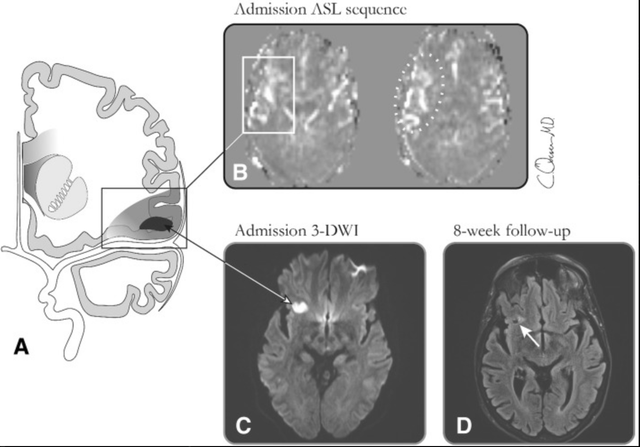

In [76]:
response = requests.get(image_question1["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [77]:
input_data = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": image_question1["image_url"]}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
}

result = invoke_realtime_endpoint(input_data)
output_content = result['choices'][0]['message']['content']

reasoning, content = extract_reasoning_and_content(output_content)
if reasoning:
    print_colored(reasoning, 'green')
if content:
    print_colored(content, 'reset')

First, I need to carefully analyze the image provided and understand what each labeled section represents. The diagram is divided into several parts, each illustrating different aspects of brain imaging related to ischemic stroke.

Starting from the leftmost part (A), it shows a schematic cross-section of the brain highlighting an area affected by ischemia. This likely indicates the region where the infarct or ischemic damage has occurred.

Moving rightwards, there's a box labeled "B" which contains two images side by side under the heading "Admission ASL sequence." ASL stands for Arterial Spin Labeling, a type of MRI technique used to measure cerebral blood flow. These images show perfusion data at admission, possibly indicating areas of reduced blood flow that might correspond to either the infarct core or the penumbra zone.

Below this, there's another image labeled "C," titled "Admission 3-DWI." DWI refers to Diffusion-Weighted Imaging, which is sensitive to acute ischemic changes.

#### Image + Text Inference (Offline)

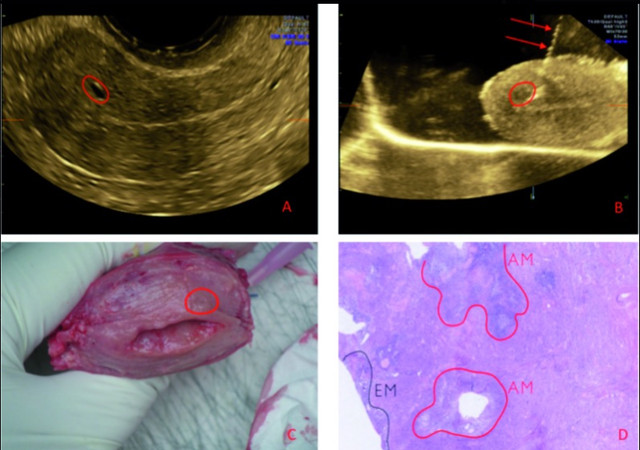

In [79]:
response = requests.get(image_question2["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [80]:
image_base64 = base64.b64encode(response.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

In [81]:
input_data = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
}

result = invoke_realtime_endpoint(input_data)
output_content = result['choices'][0]['message']['content']

reasoning, content = extract_reasoning_and_content(output_content)
if reasoning:
    print_colored(reasoning, 'green')
if content:
    print_colored(content, 'reset')

First, I observe that the user has provided four images labeled A through D, each showing different views or representations of uterine anatomy. The question asks specifically about "image D," so my focus should be on identifying what is depicted there.

Starting with image D itself (bottom right), it shows a histological section stained with hematoxylin and eosin (H&E). The tissue appears to have distinct layers marked as EM (endometrium) and AM (myometrium). There is also an outlined area within the endometrium containing glandular structures. This suggests that the image highlights the microscopic structure of the uterine lining, particularly focusing on the endometrium and its glands.

Next, I compare this with the other options:
- Option A refers to normal uterus tissue, which could be broad but doesn't specify the layer.
- Option B mentions a needle-marked zone, likely related to a procedure such as biopsy or ablation; no such marking is visible here.
- Option C describes microcy

### 3.1 Real-time inference response as a stream via Amazon SageMaker Endpoint

In [83]:
def invoke_streaming_endpoint(record):
    try:
        response = sm_runtime.invoke_endpoint_with_response_stream(
            EndpointName=model_name,
            Body=json.dumps(record),
            ContentType="application/json",
            Accept="text/event-stream"
        )

        buffer = ""  # Buffer for incomplete chunks

        for event in response["Body"]:
            if "PayloadPart" in event:
                chunk = event["PayloadPart"]["Bytes"].decode("utf-8")
                buffer += chunk  # Accumulate chunks in buffer

                # Process complete lines (those ending with \n)
                while '\n' in buffer:
                    line, buffer = buffer.split('\n', 1)  # Extract first line, keep rest
                    line = line.strip()

                    if line.startswith("data:"):
                        try:
                            data = json.loads(line[5:].strip())
                            if "choices" in data and len(data["choices"]) > 0:
                                choice = data["choices"][0]
                                if "text" in choice:
                                    yield choice["text"]
                                elif "delta" in choice and "content" in choice["delta"]:
                                    content = choice["delta"]["content"]
                                    if content:  # Only yield non-empty content
                                        yield content
                        except json.JSONDecodeError:
                            continue

            elif "ModelStreamError" in event:
                error = event["ModelStreamError"]
                yield f"\nStream error: {error['Message']} (Error code: {error['ErrorCode']})"
                break
            elif "InternalStreamFailure" in event:
                failure = event["InternalStreamFailure"]
                yield f"\nInternal stream failure: {failure['Message']}"
                break

        # Process any remaining data in buffer after stream ends
        if buffer.strip().startswith("data:"):
            try:
                data = json.loads(buffer.strip()[5:].strip())
                if "choices" in data and len(data["choices"]) > 0:
                    choice = data["choices"][0]
                    if "text" in choice:
                        yield choice["text"]
                    elif "delta" in choice and "content" in choice["delta"]:
                        content = choice["delta"]["content"]
                        if content:
                            yield content
            except json.JSONDecodeError:
                pass

    except Exception as e:
        yield f"\nAn error occurred during streaming: {str(e)}"

#### Chat Completion

In [84]:
payload = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": prompt1}
    ],
    "max_tokens": 2048,
    "temperature": 0.7,
    "top_p": 0.95,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

<think>Okay, let's tackle this question step by step. So, we have a 23-year-old pregnant woman at 22 weeks gestation presenting with dysuria (burning upon urination) that started one day ago. She's tried drinking more water and cranberry extract without improvement. Vital signs are normal—afebrile, normal BP, pulse, resp rate, O2 sat. No costovertebral angle tenderness (CVA tenderness), which makes me think it's not pyelonephritis since that usually causes flank pain or tenderness. The uterus is gravid as expected.

First, I need to figure out what infection she has. Dysuria in pregnancy could be cystitis (UTI). Since she's pregnant, UTIs can be more concerning because they can lead to complications like pyelonephritis, preterm labor, etc. But here, no fever, no CVA tenderness, so likely lower UTI (cystitis) rather than upper (pyelo).

Now, the next step is choosing the appropriate antibiotic. Important factors here are that she's pregnant, so some antibiotics are contraindicated. Let'

#### Text Completion

In [85]:
payload = {
    "model": "/opt/ml/model",
    "prompt": prompt2,
    "max_tokens": 2048,
    "temperature": 0.7,
    "top_p": 0.95,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

 What can I do to help myself? The Fever and Pain Management section has the following options: rest, hydration, OTC meds like acetaminophen or ibuprofen, and seeking medical help if symptoms worsen. The body's response to infection includes inflammation, which causes pain and fever. Resting helps the body conserve energy for fighting infection, and hydration maintains bodily functions. Fever reducers lower temperature, reducing strain on the immune system. If the infection is severe, professional care may be needed.

In summary, the body fights infections through rest, fluids, and medications; if symptoms are extreme, seeing a doctor is essential.</think>

The body's response to an infection involves several processes that aim to combat the invading pathogen while minimizing harm to itself. Fever reducers help alleviate symptoms but don't directly fight the infection. Rest conserves energy, allowing the immune system to focus on combating the infection. Hydration maintains vital bodil

#### Image + Text Inference (Online)

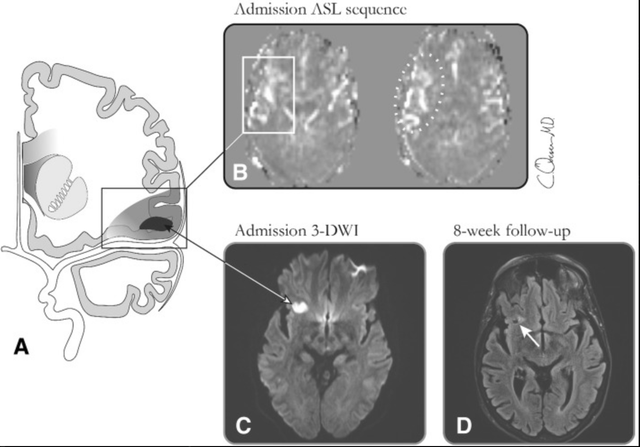

In [86]:
response = requests.get(image_question1["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [87]:
payload = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": image_question1["image_url"]}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

<think>First, I observe that the user is asking about what panel D illustrates based on the provided image. The image contains multiple panels labeled A through D, each showing different aspects of brain imaging related to stroke or ischemia.

Panel A appears to be an anatomical diagram highlighting a specific region of the brain, likely indicating where the subsequent images focus. Panel B shows two images side by side from an Admission ASL (arterial spin labeling) sequence, which measures cerebral blood flow. These images seem to highlight areas of reduced perfusion, possibly corresponding to ischemic regions.

Panel C is labeled as "Admission 3-DWI," referring to diffusion-weighted imaging, which is sensitive to acute ischemic changes. There is a bright spot indicated by an arrow here, suggesting an area of restricted diffusion consistent with an infarct core.

Panel D is titled "8-week follow-up" and shows another MRI scan. The arrow points to a region that seems to correspond to t

#### Image + Text Inference (Offline)

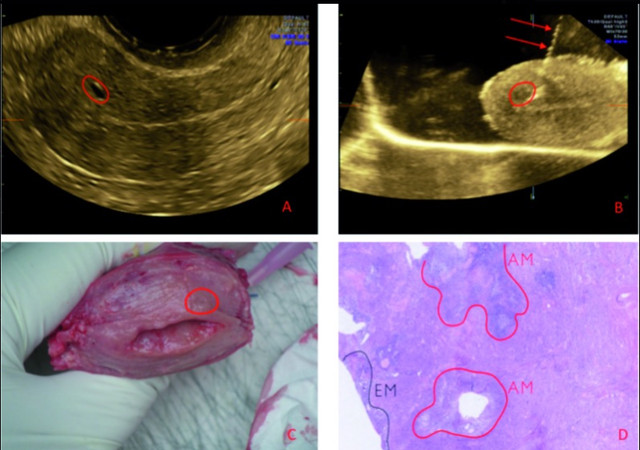

In [88]:
response = requests.get(image_question2["image_url"])
response.raise_for_status()
img = PILImage.open(io.BytesIO(response.content))
display(img)

In [89]:
image_base64 = base64.b64encode(response.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

In [90]:
payload = {
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
    "stream": True
}

for chunk in invoke_streaming_endpoint(payload):
    print(chunk, end="", flush=True)

<think>First, I observe that the user has provided four images labeled A through D, each showing different views or representations of uterine structures. The question asks specifically about "image D," so my focus should be on identifying what is depicted there.

Starting with image D itself (bottom right), it shows a histological section stained with hematoxylin and eosin (H&E). The tissue appears to have glandular structures outlined by red lines. These glands are irregularly shaped and appear embedded within a stromal background. The labels AN and EM correspond to areas likely representing the endometrial glands and stroma respectively. This suggests that this image is highlighting specific features of the endometrium.

Next, I compare image D with the other images for context. Image A and B are ultrasound scans, where a red circle marks a particular area—likely corresponding to an abnormality or a region of interest. Image C shows a gross specimen of the uterus with a marked area 

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the endpoint to avoid being charged.

In [91]:
model.sagemaker_session.delete_endpoint(model_name)
model.sagemaker_session.delete_endpoint_config(model_name)

## 4. Batch inference

In [10]:
validation_json_file_name1 = "input1.json"
validation_json_file_name2 = "input2.json"
validation_json_file_name3 = "input3.json"
validation_input_json_path = f"s3://{s3_bucket}/{model_name}/validation-input/"
validation_output_json_path = f"s3://{s3_bucket}/{model_name}/validation-output/"


def write_and_upload_to_s3(input_data, file_name):
    s3_client.put_object(
        Bucket=s3_bucket,
        Key=f"{model_name}/validation-input/{file_name}",
        Body=(bytes(input_data.encode("UTF-8"))),
    )

In [26]:
# JSON string payload for text-only prompts
payload1 = json.dumps({
    "model": "/opt/ml/model",
    "prompt": [f"{system_prompt}\n\nUser: {prompt}\n\nAssistant:" for prompt in prompts],
    "max_tokens": 2048,
    "temperature": 0.6,
    "top_p": 0.95,
    "top_k": 20,
    "min_p": 0.0,
    "presence_penalty": 0.0,
})



# Download and encode image
response1 = requests.get(image_question1["image_url"])
response1.raise_for_status()
image_base64 = base64.b64encode(response1.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

# JSON string payload for image + text
payload2 = json.dumps({
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question1["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
})



# Download and encode image
response2 = requests.get(image_question2["image_url"])
response2.raise_for_status()
image_base64 = base64.b64encode(response2.content).decode("utf-8")
data_url = f"data:image/jpeg;base64,{image_base64}"

# JSON string payload for image + text
payload3 = json.dumps({
    "model": "/opt/ml/model",
    "messages": [
        {"role": "system", "content": system_prompt},
        {
            "role": "user",
            "content": [
                {"type": "text", "text": image_question2["question"]},
                {"type": "image_url", "image_url": {"url": data_url}}
            ]
        }
    ],
    "max_tokens": 2048,
    "temperature": 0.15,
})


# Upload both
write_and_upload_to_s3(payload1, validation_json_file_name1)
write_and_upload_to_s3(payload2, validation_json_file_name2)
write_and_upload_to_s3(payload3, validation_json_file_name3)

In [ ]:
transformer = model.transformer(
    instance_count=1,
    instance_type=batch_transform_inference_instance_type,
    accept="application/json",
    output_path=validation_output_json_path,
)
transformer.transform(validation_input_json_path, content_type="application/json")
transformer.wait()

In [ ]:
from urllib.parse import urlparse

def retrieve_json_output_from_s3(validation_file_name):

    parsed_url = urlparse(transformer.output_path)
    file_key = f"{parsed_url.path[1:]}{validation_file_name}.out"
    response = s3_client.get_object(Bucket=s3_bucket, Key=file_key)
    result = json.loads(response["Body"].read().decode("utf-8"))

    for idx, choice in enumerate(result.get("choices", [])):
        if "text" in choice:
            content = choice["text"]
        elif "message" in choice and "content" in choice["message"]:
            content = choice["message"]["content"]
        else:
            content = "[No text or message content found]"

        print(f"Response {idx + 1}:\n{content}\n{'=' * 75}")

In [30]:
retrieve_json_output_from_s3(validation_json_file_name1)

Response 1:
 Maintaining good kidney health involves several steps, including staying hydrated, managing blood pressure, avoiding excessive protein intake, and monitoring kidney function through regular check-ups. The answer is structured under clear subheadings for readability.</>

Kidney health is vital for overall body function, and neglecting it can lead to serious complications like chronic kidney disease or failure to filter waste products. The answer is divided into actionable steps under clear headings, such as "Hydration," "Blood Pressure," "Protein Intake," "Regular Check-Ups," and "When to Seek Help." The response includes practical advice tailored to each section, emphasizing prevention and early detection of issues. The user's question about maintaining kidney health is addressed comprehensively by these specific strategies.</boxed{Maintaining Good Kidney Health} provides a detailed roadmap for readers to follow. Each subheading offers concise, evidence-based recommendatio

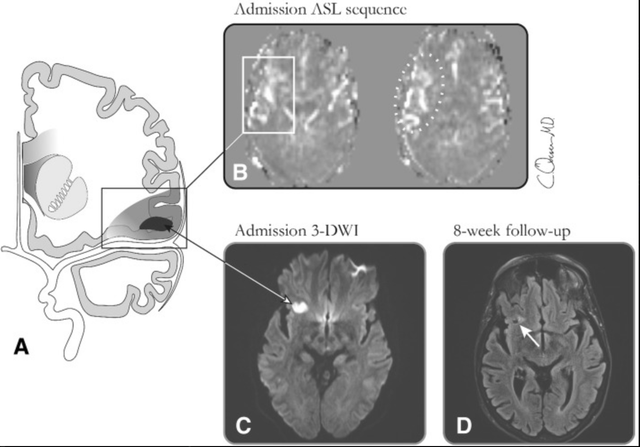

Response 1:
<think>First, I need to carefully analyze the image provided and understand what each labeled section represents. The diagram is divided into multiple panels (A, B, C, D), each illustrating different aspects of brain imaging related to an ischemic event.

Panel A shows a schematic of the brain with a highlighted region that appears to represent an area affected by stroke or ischemia. This likely corresponds to the infarct core because it's a shaded darkened area within the brain tissue.

Panel B contains two images labeled "Admission ASL sequence." ASL stands for Arterial Spin Labeling, which is an MRI technique used to measure cerebral blood flow. These images show areas of reduced perfusion, indicating regions with decreased blood flow. Since ASL measures perfusion, this could be showing either the infarct core or the penumbra zone depending on severity.

Panel C is labeled "Admission 3-DWI," referring to diffusion-weighted imaging. DWI is sensitive to cytotoxic edema cau

In [31]:
img = PILImage.open(io.BytesIO(response1.content))
display(img)
retrieve_json_output_from_s3(validation_json_file_name2)

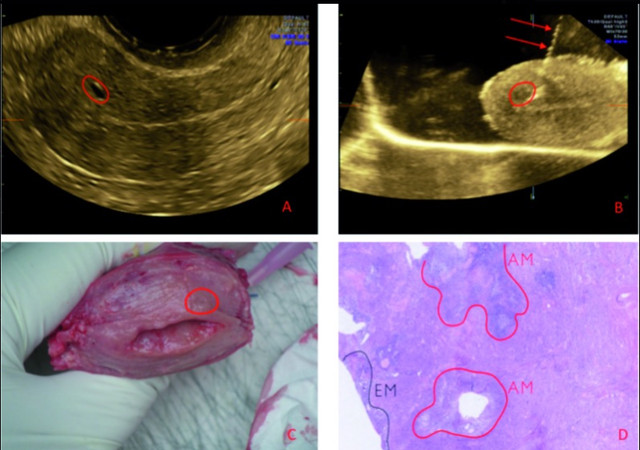

Response 1:
<think>First, I observe that the user has provided four images labeled A through D, each showing different views or representations of uterine structures. The question asks specifically about "image D," so my focus should be on identifying what is depicted there.

Starting with Image D itself (bottom right), it appears to be a histological section stained with hematoxylin and eosin (H&E), as indicated by the purple and pink coloration typical of such stains. The red outline highlights two distinct regions within the tissue. The labels "EM" and "AM" inside these outlined areas suggest they correspond to specific anatomical or histological zones. In uterine histology, "EM" commonly stands for Endometrium, which lines the inner surface of the uterus, while "AM" likely refers to the Arcuate Myometrium, part of the muscular layer beneath the endometrium.

Comparing this to other images:
- Image A shows an ultrasound view of the uterus with a marked area.
- Image B also shows an 

In [32]:
img = PILImage.open(io.BytesIO(response2.content))
display(img)
retrieve_json_output_from_s3(validation_json_file_name3)

Congratulations! You just verified that the batch transform job is working as expected. Since the model is not required, you can delete it. Note that you are deleting the deployable model. Not the model package.

In [ ]:
model.delete_model()

### Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

